# **一个VAE算法的简单实现**
## **算法概述**
- 与传统的AE有相似的过程，图片->编码->图片（生成特指编码->图片的过程）
- 与传统AE不同点有下：
    - 传统AE中图片->编码产生的编码仅代表一组高维特征，VAE中产生的编码有两组，两组编码分别代表高斯分布的$\mu$和$\sigma$
    - 传统AE中编码->图片过程是直接从编码到图片的端到端的过程，VAE则是利用一标准高斯分布的采样，通过重参数化技巧得到新编码，该新编码执行编码->图片的过程。
- VAE下采样阶段使用传统的Conv层，最后一层的输出的特征拉平后通过两个线性层得到$\mu$和$\sigma$
- VAE上采样阶段之前，将重参数化得到的编码变为(b,c,h,w)的格式，使用ConvTrans层将编码上采样至原图大小

论文链接：*https://docs.popo.netease.com/docs/9b877dd824ba440cb286d6f7923d1dbb*

In [1]:
import torch
from typing import List, Callable, Union, Any, TypeVar, Tuple
# from torch import tensor as Tensor

Tensor = TypeVar('torch.tensor')

device = 0 if torch.cuda.is_available else "cpu"
# device = "cpu"
# dataset_name = "mnist"
dataset_name = "fashion_mnist" # 一个时装数据集，以灰度图的形式保存了各种时装的照片

In [2]:
from torch import nn
from abc import abstractmethod

class BaseVAE(nn.Module):
    
    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size:int, current_device: int, **kwargs) -> Tensor:
        raise NotImplementedError

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass

In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [4]:
class BetaVAE(BaseVAE):
    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 beta: int = 6,
                 gamma:float = 1000.,
                 max_capacity: int = 25,
                 Capacity_max_iter: int = 1e5,
                 loss_type:str = 'B',
                 **kwargs) -> None:
        super(BetaVAE, self).__init__()

        self.latent_dim = latent_dim
        self.beta = beta
        self.gamma = gamma
        self.loss_type = loss_type
        self.C_max = torch.Tensor([max_capacity])
        self.C_stop_iter = Capacity_max_iter
        
        modules = []
        hidden_dims = [32, 64, 128, 256]
        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels,out_channels=h_dim,
                             kernel_size=3,stride=2,padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim
            
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)
        
        # Build Decoder
        modules = []
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1]*4)
        hidden_dims.reverse()

        for i in range(len(hidden_dims)-1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],hidden_dims[i+1],
                                      kernel_size=3,stride=2,padding=1,
                                      output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i+1]),
                    nn.LeakyReLU())
                )
        self.decoder = nn.Sequential(*modules)
        
        # Build final layer
        self.final_layer = nn.Sequential(nn.ConvTranspose2d(hidden_dims[-1],
                                                      hidden_dims[-1],
                                                      kernel_size=3,
                                                      stride=2,
                                                      padding=1,
                                                      output_padding=1),
                                   nn.BatchNorm2d(hidden_dims[-1]),
                                   nn.LeakyReLU(),
                                   nn.Conv2d(hidden_dims[-1],out_channels=1,
                                            kernel_size=3,padding=1),
                                   nn.Tanh())
        
    def encode(self, input):
        result = self.encoder(input)
        result = torch.flatten(result,start_dim=1)
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        
        return [mu, log_var]
    
    def decode(self, z):
        result = self.decoder_input(z)
        result = result.view(-1,256,2,2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(logvar)
        return eps*std + mu
    
    def forward(self, input, **kwargs):
        mu, logvar = self.encode(input)
        z = self.reparameterize(mu, logvar)
        result = self.decode(z)
        return [result, input, mu, logvar]
    
    def loss_calculate(self,*args,**kwargs):
        
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]
        kld_weight = 0.00025
        recons_loss = F.mse_loss(recons, input)
        kld_loss = torch.mean(-0.5 * torch.sum(1+log_var - log_var.exp() - mu ** 2, dim=1),dim=0)
        loss = recons_loss + self.beta * kld_weight * kld_loss
        
        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':kld_loss}
    
    @torch.no_grad()
    def sample(self, num_samples):
        z = torch.randn(num_samples, self.latent_dim)
        z = z.to(device)
        
        samples = self.decode(z)
        samples = samples.cpu().numpy()
        return samples

In [5]:
import torch
import torchvision
from torch.utils.data import DataLoader


In [6]:
batch_size_train = 32

In [7]:
from torchvision import transforms
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision.transforms import Compose


dataset = load_dataset(dataset_name)

transform = Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Lambda(lambda t:(t*2) - 1)
])

def transforms_(examples):
    examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
    del examples["image"]
    return examples

transformed_dataset = dataset.with_transform(transforms_).remove_columns("label")

dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size_train, shuffle=True)

Found cached dataset fashion_mnist (/home/ygq/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
import torch.optim as optim
vae_model = BetaVAE(1,128)
vae_model.to(device)
optimizer = optim.Adam(vae_model.parameters(), lr=0.005)

In [9]:
def train(epoch):
    loss_sum_in_one_batch = 0
    batch_count = 0
    for batch_idx, batch in enumerate(dataloader):
        optimizer.zero_grad()
        data = batch["pixel_values"].to(device)
        result = vae_model(data)
        loss_dict = vae_model.loss_calculate(*result, M_N=None)
        loss_dict['loss'].backward()
        optimizer.step()
        loss_sum_in_one_batch += loss_dict['loss'].item()
        batch_count += 1
        if batch_count % 100 == 0:
            print(f"epoch {epoch} batch count {batch_count} , avg loss is {loss_sum_in_one_batch / batch_count}")


In [10]:
import matplotlib.pyplot as plt
def generate_image(images):
    image = images[0,0,:,:]
    plt.imshow(image, cmap='gray')
    plt.show()

epoch 1 batch count 100 , avg loss is 0.30468316212296487
epoch 1 batch count 200 , avg loss is 0.22892067611217498
epoch 1 batch count 300 , avg loss is 0.1982484910140435
epoch 1 batch count 400 , avg loss is 0.17916565589606762
epoch 1 batch count 500 , avg loss is 0.16563695518672467
epoch 1 batch count 600 , avg loss is 0.1550777380168438
epoch 1 batch count 700 , avg loss is 0.1473218215469803
epoch 1 batch count 800 , avg loss is 0.14095911972224712
epoch 1 batch count 900 , avg loss is 0.1356015999035703
epoch 1 batch count 1000 , avg loss is 0.13123824614286422
epoch 1 batch count 1100 , avg loss is 0.12763833309439096
epoch 1 batch count 1200 , avg loss is 0.12446606833487749
epoch 1 batch count 1300 , avg loss is 0.12160853915489638
epoch 1 batch count 1400 , avg loss is 0.11915182529815606
epoch 1 batch count 1500 , avg loss is 0.11691316638886928
epoch 1 batch count 1600 , avg loss is 0.11490346179809421
epoch 1 batch count 1700 , avg loss is 0.11306416425196564
epoch 1 ba

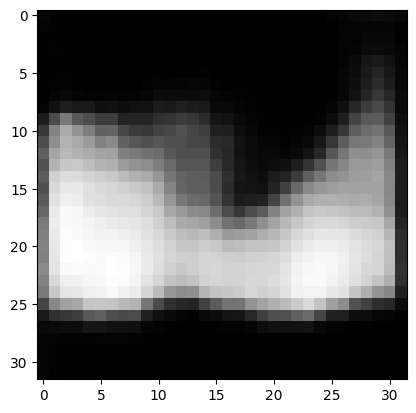

epoch 2 batch count 100 , avg loss is 0.08207679130136966
epoch 2 batch count 200 , avg loss is 0.08148792508989572
epoch 2 batch count 300 , avg loss is 0.08114826371272404
epoch 2 batch count 400 , avg loss is 0.08106474544852972
epoch 2 batch count 500 , avg loss is 0.08082509002089501
epoch 2 batch count 600 , avg loss is 0.08058312702924013
epoch 2 batch count 700 , avg loss is 0.08037440576723644
epoch 2 batch count 800 , avg loss is 0.08013935402035713
epoch 2 batch count 900 , avg loss is 0.08001382603413529
epoch 2 batch count 1000 , avg loss is 0.07994466721266508
epoch 2 batch count 1100 , avg loss is 0.07968426686796275
epoch 2 batch count 1200 , avg loss is 0.07952964461718996
epoch 2 batch count 1300 , avg loss is 0.0793208829084268
epoch 2 batch count 1400 , avg loss is 0.07898846697328346
epoch 2 batch count 1500 , avg loss is 0.0787434394682447
epoch 2 batch count 1600 , avg loss is 0.07861469026654959
epoch 2 batch count 1700 , avg loss is 0.07845972100601477
epoch 2 

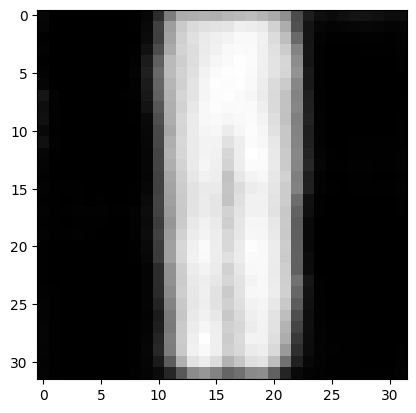

epoch 3 batch count 100 , avg loss is 0.07465025711804628
epoch 3 batch count 200 , avg loss is 0.07507479140534996
epoch 3 batch count 300 , avg loss is 0.07542957821240028
epoch 3 batch count 400 , avg loss is 0.07557683927938343
epoch 3 batch count 500 , avg loss is 0.07525235698372125
epoch 3 batch count 600 , avg loss is 0.07512312640125553
epoch 3 batch count 700 , avg loss is 0.07486733409443072
epoch 3 batch count 800 , avg loss is 0.0746731265168637
epoch 3 batch count 900 , avg loss is 0.07463098801672459
epoch 3 batch count 1000 , avg loss is 0.07465849824994802
epoch 3 batch count 1100 , avg loss is 0.0745655173029412
epoch 3 batch count 1200 , avg loss is 0.07450595364285012
epoch 3 batch count 1300 , avg loss is 0.07437296782835172
epoch 3 batch count 1400 , avg loss is 0.07434476972424559
epoch 3 batch count 1500 , avg loss is 0.07420780228823423
epoch 3 batch count 1600 , avg loss is 0.07407351706409827
epoch 3 batch count 1700 , avg loss is 0.07398734668379321
epoch 3 

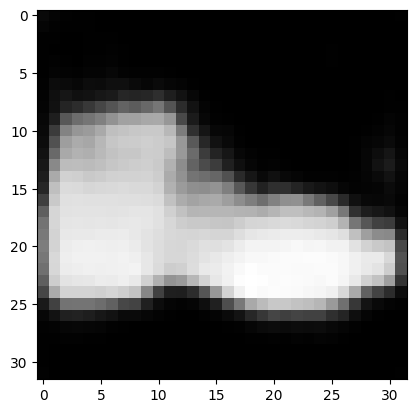

epoch 4 batch count 100 , avg loss is 0.07243923336267472
epoch 4 batch count 200 , avg loss is 0.07279763862490654
epoch 4 batch count 300 , avg loss is 0.07263629514724017
epoch 4 batch count 400 , avg loss is 0.07219489973969757
epoch 4 batch count 500 , avg loss is 0.07192787435650826
epoch 4 batch count 600 , avg loss is 0.07194979606817166
epoch 4 batch count 700 , avg loss is 0.07186457169907434
epoch 4 batch count 800 , avg loss is 0.07188430044800043
epoch 4 batch count 900 , avg loss is 0.0719022005258335
epoch 4 batch count 1000 , avg loss is 0.07172476186975837
epoch 4 batch count 1100 , avg loss is 0.07179612260989167


In [ ]:
vae_model.train()
for i in range(10):
    train(i+1)
    generate_image(vae_model.sample(1))
torch.save(vae_model.state_dict(),"./model.pt")